In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

In [306]:
from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [348]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core

In [411]:
get_t = lambda time_point, x1, x2 ,m : (x1 - x2)/m + time_point

def get3x(x_dist=1.0, middle_len=1.0):

    mind_speed = 3.5
    # 3 stays, 2 equal
    x_midpt_1 = -x_dist/2
    x_midpt_2 = +x_dist/2    
    
    x_locs = [x_midpt_1, x_midpt_2]
    
    '''t_bounds = [6.0, get_t(12, -1, mind_speed), 
                get_t(12, 1, mind_speed), 18.0]
    '''
    t_dist = abs(12 - get_t(12, x_locs[0], 0, mind_speed))
    t_bounds = [6.0, 
                12-t_dist, 
                12+t_dist,
                18.0]   

    return t_bounds, x_locs

In [412]:
get3x(1.0, 1/6)

([6.0, 11.857142857142858, 12.142857142857142, 18.0], [-0.5, 0.5])

<Figure size 1440x720 with 0 Axes>

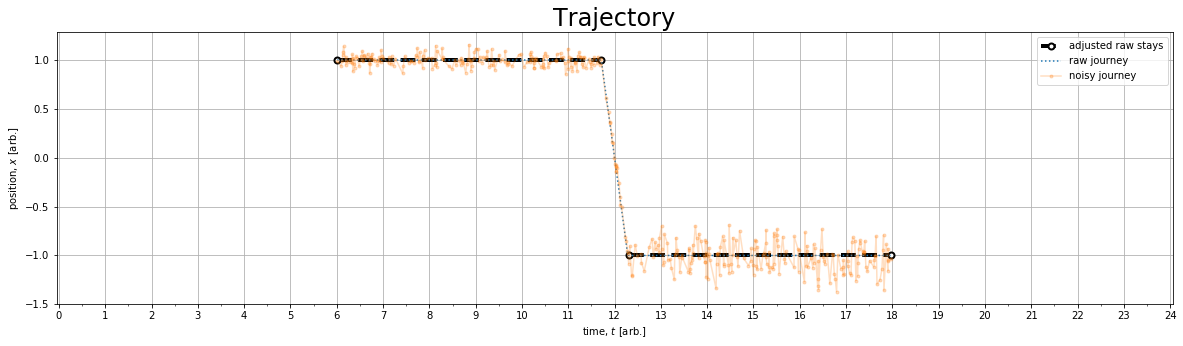

In [416]:
stays = get2(2.0)

time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [290]:
time_thresh = 1/6
dist_thresh=0.25

In [291]:
clusters = list(range(time_arr.size))

In [292]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [293]:
clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
len(clusters)

7

In [294]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [295]:
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
len(clusters_rev)

9

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

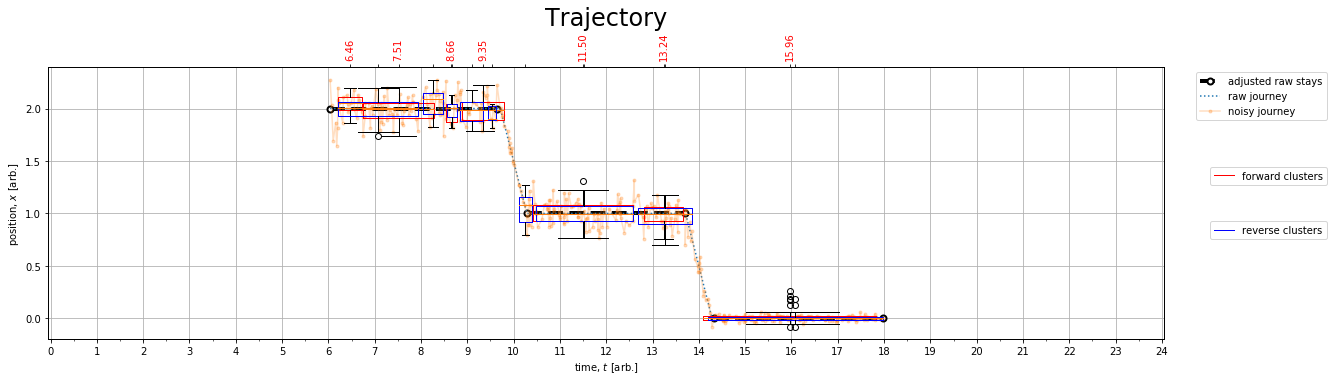

In [296]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [86]:
from helper__metric_box__explore import eval_synth_data

In [73]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.925
 0.727
[[ 28  15]
 [ 70 186]]


In [74]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.809
 0.613
[[  6  37]
 [ 99 157]]


In [87]:
gaps = [time_arr[c2[0]]-time_arr[c1[-1]] for c1, c2 in zip(clusters[:-1],clusters[1:])]
for gap in gaps:
    print(gap, gap>time_thresh)

0.07333333333333325 False
0.0919444444444446 False
0.1708333333333334 True
0.6097222222222225 True
0.06222222222222307 False
0.0066666666666659324 False
0.02777777777777679 False
0.02777777777777679 False
0.039444444444443505 False
0.2038888888888888 True
0.05222222222222328 False
0.07694444444444315 False
0.1416666666666675 False
0.25 True
0.1494444444444447 False
0.30972222222222 True


In [88]:
get_gap_time = lambda c1, c2: time_arr[c2[0]]-time_arr[c1[-1]]

In [89]:
#def merge_gaps(t_arr, x_arr, clusters):
new_clusters = []    
for c1, c2 in zip(clusters[:-1],clusters[1:]):

    dt = time_arr[c2[0]]-time_arr[c1[-1]]
    print(c1[0],c1[-1],c2[0],c2[-1],dt,dt>time_thresh)

1 21 24 32 0.07333333333333325 False
24 32 34 38 0.0919444444444446 False
34 38 43 46 0.1708333333333334 True
43 46 74 114 0.6097222222222225 True
74 114 116 129 0.06222222222222307 False
116 129 131 151 0.0066666666666659324 False
131 151 153 177 0.02777777777777679 False
153 177 179 201 0.02777777777777679 False
179 201 203 222 0.039444444444443505 False
203 222 225 270 0.2038888888888888 True
225 270 272 307 0.05222222222222328 False
272 307 309 328 0.07694444444444315 False
309 328 331 338 0.1416666666666675 False
331 338 345 364 0.25 True
345 364 369 388 0.1494444444444447 False
369 388 400 416 0.30972222222222 True


In [90]:
m,n = 0,0
while n < len(clusters):
    c1 = clusters[n].copy()

    print(m,n,c1[0],c1[-1])
    n+=1

0 0 1 21
0 1 24 32
0 2 34 38
0 3 43 46
0 4 74 114
0 5 116 129
0 6 131 151
0 7 153 177
0 8 179 201
0 9 203 222
0 10 225 270
0 11 272 307
0 12 309 328
0 13 331 338
0 14 345 364
0 15 369 388
0 16 400 416


In [176]:
m = 0
new_clusters = []
while m < len(clusters):
    
    n = m + 1
    
    clust = clusters[m].copy()
    
    while n < len(clusters):
        c1 = clusters[m].copy()
        c2 = clusters[n].copy()
        
        gap_time = get_gap_time(clusters[m],clusters[n])
        
        print(m,n,c1[0],c1[-1],c2[0],c2[-1],clust[0],clust[-1],f"{gap_time:.3f}",int(gap_time <= time_thresh))
        
        #if (gap_time <= time_thresh) & (abs(noise_arr[c1].mean()-noise_arr[c2].mean())<0.05):
        if gap_criterion(0.025, time_thresh)(time_arr,noise_arr,c1,c2):
            clust.extend(clusters[n])
            n+=1
        else:
            new_clusters.append(clust)
            m = n
            clust = clusters[m].copy()
            n += 1

    m += 1
new_clusters.append(clust)

0 1 1 21 24 32 1 21 0.073 1
1 2 24 32 34 38 24 32 0.092 1
2 3 34 38 43 46 34 38 0.171 0
3 4 43 46 74 114 43 46 0.610 0
4 5 74 114 116 129 74 114 0.062 1
5 6 116 129 131 151 116 129 0.007 1
6 7 131 151 153 177 131 151 0.028 1
7 8 153 177 179 201 153 177 0.028 1
8 9 179 201 203 222 179 201 0.039 1
9 10 203 222 225 270 203 222 0.204 0
10 11 225 270 272 307 225 270 0.052 1
11 12 272 307 309 328 272 307 0.077 1
12 13 309 328 331 338 309 328 0.142 1
13 14 331 338 345 364 331 338 0.250 0
14 15 345 364 369 388 345 364 0.149 1
15 16 369 388 400 416 369 388 0.310 0


In [92]:
new_clusters[-1][0],new_clusters[-1][-1]

(400, 416)

In [239]:
def gap_criterion(dist_thresh, time_thresh):

    def meth(t_arr,x_arr,c1,c2):
    
        return ((get_gap_time(c1,c2) <= time_thresh) and \
              (abs(np.median(x_arr[c1])-np.median(x_arr[c2])) < dist_thresh))
    
    return meth

In [240]:
def print_metric(m,n,c1, c2, c_main, gap_time, t_thresh, dist, d_thresh):
    
    ints = f"{m:4d} {m:4d}\t"
    
    clusts = f"[{c1[0]:4d},{c1[-1]:5d}], [{c2[0]:4d},{c2[-1]:5d}], [{c_main[0]:4d},{c_main[-1]:5d}]"
    
    #dist = f"{dist:3d}" 
    #dist = f"{dist:5.3f}"
    print(ints, clusts, f"\t{gap_time:5.3f}\t{int(gap_time <= t_thresh):4d}\t", f"{dist:5.3f}\t{int(dist < d_thresh):4d}")

In [241]:
def _merge_gaps(t_arr, x_arr, clusters, dist_thresh, time_thresh):

    m = 0
    new_clusters = []
    while m < len(clusters):

        n = m + 1

        clust = clusters[m].copy()

        while n < len(clusters):
            c1 = clusters[m].copy()
            c2 = clusters[n].copy()

            gap_time = get_gap_time(c1,c2)

            dist = abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
            
            print_metric(m, n, c1, c2, clust, gap_time, time_thresh, dist, dist_thresh)
            
            if gap_criterion(dist_thresh, time_thresh)(t_arr, x_arr, c1,c2):
                clust.extend(clusters[n])
                n+=1
            else:
                new_clusters.append(clust)
                m = n
                clust = clusters[m].copy()
                n += 1

        m += 1
    
    new_clusters.append(clust)        
    
    return new_clusters

In [242]:
def merge_gaps(t_arr, x_arr, clusters, dist_thresh, time_thresh):
    
    new_clusters = _merge_gaps(t_arr, x_arr, clusters, dist_thresh, time_thresh).copy()
    
    gaps = [gap_criterion(dist_thresh, time_thresh)(t_arr,x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]

    for gap in gaps:
        print(gap)    
    
    while any(gaps):
        
        new_clusters = _merge_gaps(t_arr, x_arr, new_clusters, dist_thresh, time_thresh).copy()
    
        gaps = [gap_criterion(dist_thresh, time_thresh)(t_arr,x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]
        
    return new_clusters

In [243]:
new_clusters = _merge_gaps(time_arr, noise_arr, clusters, dist_thresh/5, time_thresh)

   0    0	 [   1,   21], [  24,   32], [   1,   21] 	0.073	   1	 0.075	   0
   1    1	 [  24,   32], [  34,   38], [  24,   32] 	0.092	   1	 0.061	   0
   2    2	 [  34,   38], [  43,   46], [  34,   38] 	0.171	   0	 0.040	   1
   3    3	 [  43,   46], [  74,  114], [  43,   46] 	0.610	   0	 0.043	   1
   4    4	 [  74,  114], [ 116,  129], [  74,  114] 	0.062	   1	 0.152	   0
   5    5	 [ 116,  129], [ 131,  151], [ 116,  129] 	0.007	   1	 0.126	   0
   6    6	 [ 131,  151], [ 153,  177], [ 131,  151] 	0.028	   1	 0.265	   0
   7    7	 [ 153,  177], [ 179,  201], [ 153,  177] 	0.028	   1	 0.274	   0
   8    8	 [ 179,  201], [ 203,  222], [ 179,  201] 	0.039	   1	 0.140	   0
   9    9	 [ 203,  222], [ 225,  270], [ 203,  222] 	0.204	   0	 0.135	   0
  10   10	 [ 225,  270], [ 272,  307], [ 225,  270] 	0.052	   1	 0.394	   0
  11   11	 [ 272,  307], [ 309,  328], [ 272,  307] 	0.077	   1	 0.342	   0
  12   12	 [ 309,  328], [ 331,  338], [ 309,  328] 	0.142	   1	 0.101	   0
  13   13	 [

In [244]:
[gap_criterion(dist_thresh/5, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [249]:
dist_thresh/1, time_thresh

(0.25, 0.16666666666666666)

In [256]:
new_clusters = merge_gaps(time_arr, noise_arr, clusters, dist_thresh/0.5, time_thresh)

   0    0	 [   1,   21], [  24,   32], [   1,   21] 	0.073	   1	 0.075	   1
   0    0	 [   1,   21], [  34,   38], [   1,   32] 	0.497	   0	 0.015	   1
   2    2	 [  34,   38], [  43,   46], [  34,   38] 	0.171	   0	 0.040	   1
   3    3	 [  43,   46], [  74,  114], [  43,   46] 	0.610	   0	 0.043	   1
   4    4	 [  74,  114], [ 116,  129], [  74,  114] 	0.062	   1	 0.152	   1
   4    4	 [  74,  114], [ 131,  151], [  74,  129] 	0.271	   0	 0.278	   1
   6    6	 [ 131,  151], [ 153,  177], [ 131,  151] 	0.028	   1	 0.265	   1
   6    6	 [ 131,  151], [ 179,  201], [ 131,  177] 	0.733	   0	 0.539	   0
   8    8	 [ 179,  201], [ 203,  222], [ 179,  201] 	0.039	   1	 0.140	   1
   8    8	 [ 179,  201], [ 225,  270], [ 179,  222] 	0.722	   0	 0.005	   1
  10   10	 [ 225,  270], [ 272,  307], [ 225,  270] 	0.052	   1	 0.394	   1
  10   10	 [ 225,  270], [ 309,  328], [ 225,  307] 	1.088	   0	 0.736	   0
  12   12	 [ 309,  328], [ 331,  338], [ 309,  328] 	0.142	   1	 0.101	   1
  12   12	 [

In [257]:
len(new_clusters)

8

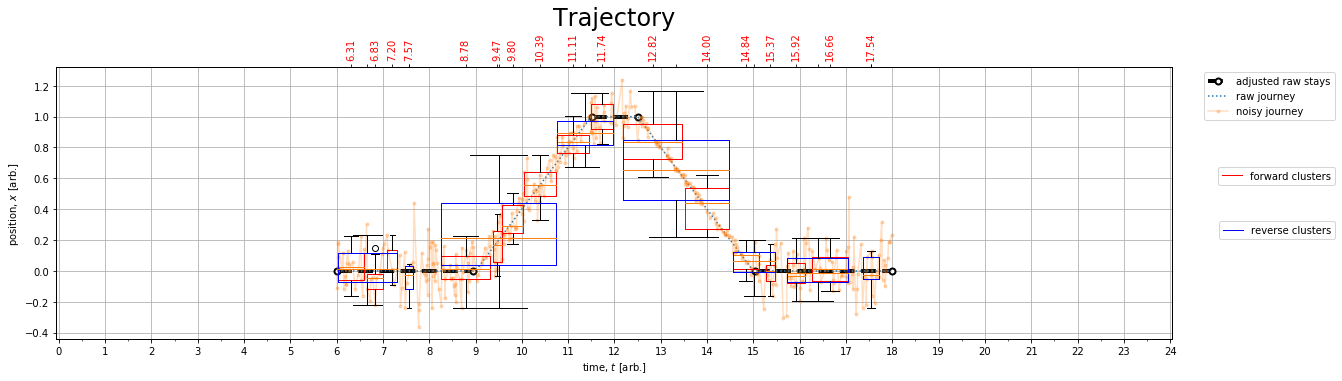

In [258]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

#ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, new_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [259]:
dist_thresh/time_thresh

1.5

In [233]:
cbase = new_clusters[-2][0]+10

In [36]:
clusters2 = get_clusters_rev(time_arr[cbase:], noise_arr[cbase:], dist_thresh, time_thresh)
clusters2 = [[c + cbase for c in c_inner] for c_inner in clusters2]

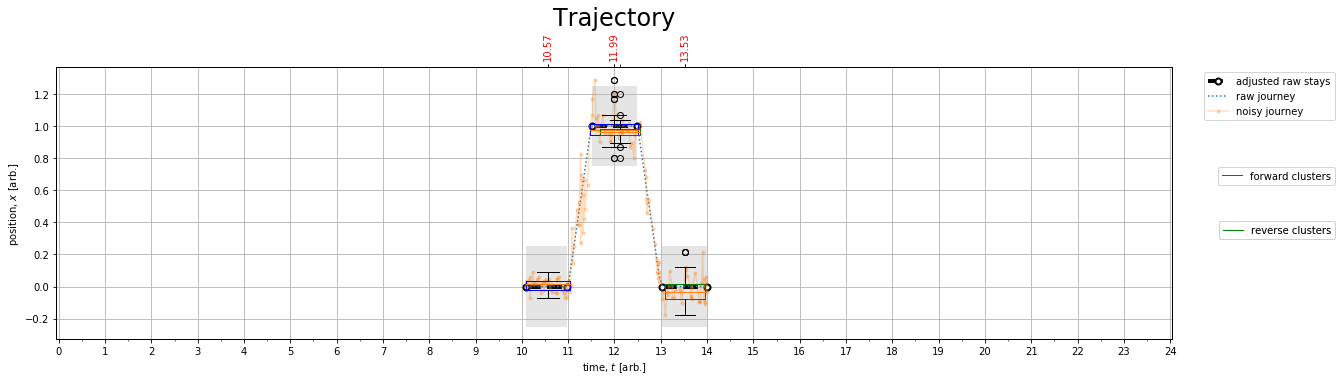

In [40]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

#ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, new_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1)



bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters2)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='green'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [60]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.944
 0.944
[[ 34   6]
 [  6 101]]


In [61]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters2)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.947
 0.505
[[37  3]
 [53 54]]


In [41]:
configs['count_thresh'] = 10

In [46]:
from stay_classification.box_classifier.box_classify import box_classifier_core
from stay_classification.box_classifier.box_method import get_mask, make_box,get_directional_indices, extend_edge

In [48]:
def get_iqr(data):
    
    q25 = np.quantile(data, 0.25, interpolation='lower')
    q75 = np.quantile(data, 0.75, interpolation='higher')
    return abs(q75 - q25)

In [42]:
def extend_cluster(t_arr, x_arr, cluster, configs, verbose=False):
    
    results = extend_edge(t_arr, x_arr, cluster[-1], cluster[0], [x_arr[cluster].mean()], configs, verbose)

    cluster += results[1]

    results = extend_edge(t_arr, x_arr, cluster[0], cluster[-1], [x_arr[cluster].mean()], configs, verbose)

    cluster = results[1] + cluster

    return cluster

In [43]:
def intersecting_bounds(a1,a2,b1,b2):
    
    return (((a1 >= b1) & (a1 <= b2)) | 
            ((a2 >= b1) & (a2 <= b2)) | 
            ((b1 >= a1) & (b1 <= a2)) | 
            ((b2 >= a1) & (b2 <= a2)))    

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])

In [44]:
def extend_clusters(t_arr, x_arr, clusters, configs, verbose=False):
    
    from stay_classification.box_classifier.box_method import extend_edge

    new_clusters = [extend_cluster(t_arr, x_arr, clusters[0].copy(), configs, verbose)]
    
    for clust in clusters[1:]:
        
        c = extend_cluster(t_arr, x_arr, clust.copy(), configs, verbose)
        
        # check the IQR is within the allowed threshold
        dist_criterion = False
        if get_iqr(x_arr[c])<2*dist_thresh:
            dist_criterion = True
            
        c_last = new_clusters[-1]            
        
        # Check if new cluster overlaps with the previous one
        embed_criterion = False
        if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)        
        
        print(f"[{ clust[0]:4d},{ clust[-1]:4d}]," + "\t"\
              f"{t_arr[clust[0]]:6.3f}...{t_arr[clust[-1]]:6.3f}" + "\t"\
              f"{x_arr[clust].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[clust]):6.3f}," + "\t\t\t"\
              f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
              f"{t_arr[c[0]]:6.3f}...{t_arr[c[-1]]:6.3f}" + "\t"\
              f"{x_arr[c].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[c]):6.3f},", \
              dist_criterion, embed_criterion)
        
        
        # check the IQR is within the allowed threshold
        dist_criterion0 = False
        if get_iqr(x_arr[clust])<2*dist_thresh:
            dist_criterion0 = True
                    
        # Check if new cluster overlaps with the previous one
        embed_criterion0 = False
        if len(new_clusters)>0:
            embed_criterion0 = inter_bounds(clust,c_last) 
            
        if dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        elif dist_criterion0 & (not embed_criterion0) & (get_iqr(x_arr[clust]) < get_iqr(x_arr[c])):
            new_clusters.append(clust)
        '''if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)
            print(f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
                  f"[{c_last[0]:4d},{c_last[-1]:4d}]")

        # ... if there is an overlap, get the one with the smaller IQR
        # ... 1. remove last, append new if dist_crit == True
        if dist_criterion & embed_criterion:
            if get_iqr(noise_arr[c])<get_iqr(noise_arr[c_last]):
                new_clusters[-1] = c       
            else:
                pass
        # ... if no overlap and dist_crit == True, append
        elif dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        else:
            pass'''
    
    return new_clusters

In [49]:
ext_clusters = extend_clusters(time_arr, noise_arr, clusters, configs)

[  59,  92],	11.470...12.518	 0.990,	 0.073,			[  58, 109],	11.421...13.030	 0.607,	 0.717, False True
[ 111, 142],	13.097...13.958	-0.018,	 0.104,			[ 110, 146],	13.057...13.996	 0.180,	 0.317, True False


In [50]:
len(ext_clusters)

2

In [51]:
c = ext_clusters[0]
print(f"[{c[0]:4d},{c[-1]:4d}] = {noise_arr[c].mean():>6.3f}, {get_iqr(noise_arr[c]):>6.3f},")
for n, c in enumerate(ext_clusters[1:]):
    
    print(f"[{c[0]:4d},{c[-1]:4d}] = {noise_arr[c].mean():>6.3f}, {get_iqr(noise_arr[c]):>6.3f},")

[   0,  67] =  0.266,  0.477,
[ 110, 146] =  0.180,  0.317,


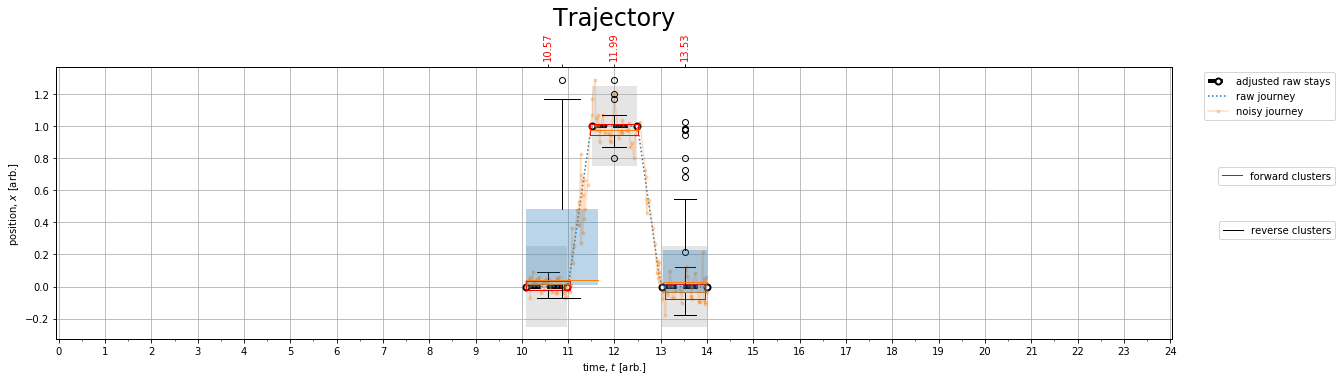

In [52]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

#ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);



bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, ext_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, patch_artist=True, boxprops=dict(color='cyan',alpha=0.3, linewidth=0 ), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

**Notes**
* extend clusters (aka the box method) fails: it captures too much and skews to a new box which is outside the preferred region.

In [62]:
prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.790
 0.776
[[18 22]
 [24 83]]


### Refinement with `box_method`

In [48]:
from collections import Counter

In [49]:
def sample_times(indices,frac=0.8):
    return np.sort(np.random.choice(np.array(indices),int(frac*len(indices)), replace=False)).tolist()
    

In [50]:
configs['slope_time_thresh'] = 0.05
configs['slope_thresh'] = abs(dist_thresh/time_thresh)
configs['count_thresh'] = 10
configs['dist_thresh'] = 0.125

start_ind, last_ind = clusters[0][0], clusters[0][-1]

init_pairs = []
final_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    indices = sample_times(range(len(time_arr)),0.99)
    
    start_ind, last_ind, mean, keep = box_classifier_core(time_arr[indices], noise_arr[indices], start_ind, last_ind, timepoint, init_pairs, configs, False)

    if keep:
        final_pairs.append((start_ind, last_ind))
    else:
        continue
    init_pairs.append([cluster[0], cluster[-1]])
    
final_pairs = list(set(final_pairs))
final_pairs

[(218, 687),
 (217, 688),
 (102, 167),
 (117, 181),
 (177, 224),
 (218, 688),
 (219, 689),
 (656, 853),
 (1, 157),
 (1, 158),
 (570, 786)]

In [51]:
mid_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    # Get a box for a given timepoint
    mean, start_ind, last_ind = make_box(time_arr, noise_arr, timepoint, configs, False)
            
    mid_pairs.append([start_ind, last_ind,])

mid_pairs

[[1, 169],
 [1, 169],
 [1, 169],
 [1, 169],
 [1, 169],
 [94, 182],
 [109, 192],
 [170, 236],
 [212, 706],
 [212, 706],
 [212, 706],
 [212, 711],
 [569, 805],
 [654, 863]]

`for m in range(len(final_pairs)):
    for n in range(m,len(final_pairs)):
        s1 = set(list(range(final_pairs[m][0],final_pairs[m][1]+1)))
        s2 = set(list(range(final_pairs[n][0],final_pairs[n][1]+1)))
        print(s1.isdisjoint(s2))`

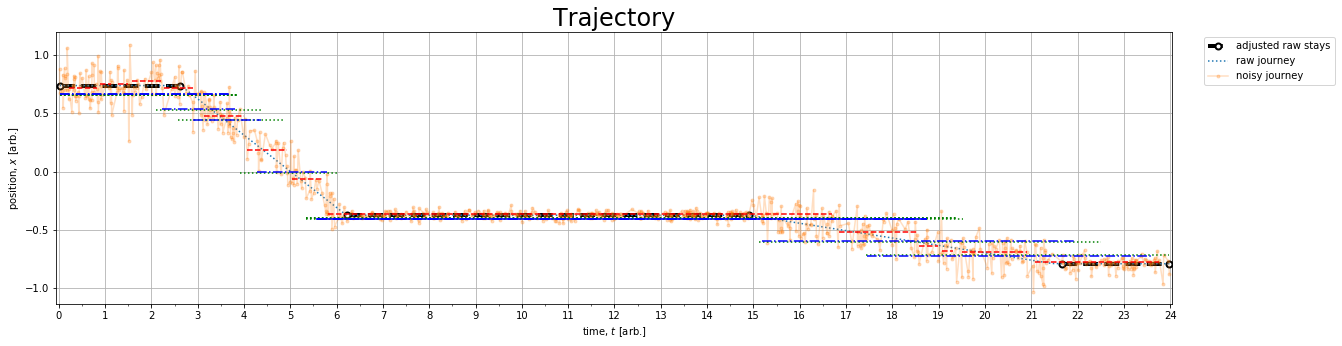

In [52]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])+.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')

for pair in mid_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:')
    
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])-.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [53]:
pairs_dur = {}
for p in final_pairs:
    dt = time_arr[p[-1]]-time_arr[p[0]]
    
    pairs_dur[tuple(p)] = dt

In [54]:
pairs_dur = {k: v for k, v in sorted(pairs_dur.items(), key=lambda item: item[1], reverse=True)}

In [55]:
pairs_dur

{(217, 688): 13.195833333333335,
 (218, 688): 13.172777777777778,
 (218, 687): 13.16472222222222,
 (219, 689): 13.130555555555555,
 (570, 786): 6.786111111111113,
 (656, 853): 6.184166666666666,
 (1, 158): 3.6602777777777775,
 (1, 157): 3.658888888888889,
 (102, 167): 1.5597222222222222,
 (177, 224): 1.4944444444444445,
 (117, 181): 1.481666666666667}

### Shifting boxes

In [56]:
from synthetic_data.trajectory import get_stay_indices

true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [57]:
final_pairs = sorted(final_pairs, key = lambda x: x[0])

In [58]:
def get_box_indices(arr, lower, upper):
    return np.where(((arr > lower) & (arr < upper)))

In [64]:
def shift_box(t_arr, x_arr, dist_thresh=None):

    def meth(pair, shift):
        
        x_arr_ = noise_arr[pair[0]:pair[1]+1]
        t_arr_ = time_arr[pair[0]:pair[1]+1]

        mean_ = x_arr_.mean()

        t0,t1 = t_arr_[0],t_arr_[-1]    

        shift = (t1-t0)/8
        mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
        mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

        x_arr_n = x_arr_[mask_n]
        t_arr_n = t_arr_[mask_n]
        x_arr_p = x_arr_[mask_p]  
        t_arr_p = t_arr_[mask_p]        

        mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
        mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)       
        
        #return abs(x_arr_[mean_mask_n].mean()-mean_), abs(x_arr_[mean_mask_p].mean()-mean_)
        return (abs(x_arr_n[mean_mask_n].mean()-mean_) < 0.025) & (abs(x_arr_p[mean_mask_p].mean()-mean_) < 0.025)
    
    
    return meth

In [65]:
len(final_pairs)

11

In [66]:
last_pairs = []
n=0
for pair in final_pairs:
    cond = shift_box(time_arr, noise_arr, dist_thresh)(pair, time_thresh/2)
    if cond: last_pairs.append(pair)
    print(n,pair, cond)
    n+=1

0 (1, 157) False
1 (1, 158) False
2 (102, 167) True
3 (117, 181) True
4 (177, 224) True
5 (217, 688) True
6 (218, 687) True
7 (218, 688) True
8 (219, 689) True
9 (570, 786) True
10 (656, 853) True


0.7095720555240634 0.6743629215779573 0.676439600659611


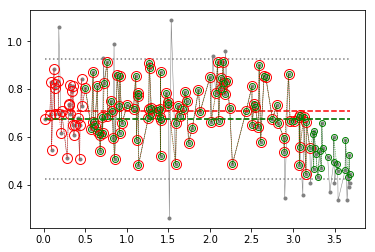

In [67]:
pair = final_pairs[1]

shift = time_thresh/2

x_arr_ = noise_arr[pair[0]:pair[1]+1]
t_arr_ = time_arr[pair[0]:pair[1]+1]

mean_ = x_arr_.mean()

t0,t1 = t_arr_[0],t_arr_[-1]    

shift = (t1-t0)/8
mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

x_arr_n = x_arr_[mask_n]
t_arr_n = t_arr_[mask_n]
x_arr_p = x_arr_[mask_p]  
t_arr_p = t_arr_[mask_p]        

mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)   

plt.plot(t_arr_, x_arr_, '.-', color='gray', lw=0.5)

plt.plot([t_arr_[0],t_arr_[-1]],[mean_,mean_], "--", color='gray', markersize=1)
plt.plot([t_arr_[0],t_arr_[-1]],[mean_+dist_thresh,mean_+dist_thresh], ":", color='gray')
plt.plot([t_arr_[0],t_arr_[-1]],[mean_-dist_thresh,mean_-dist_thresh], ":", color='gray')

#plt.plot(t_arr_n, x_arr_n, 'ro', markerfacecolor="None")
plt.plot(t_arr_n[mean_mask_n], x_arr_n[mean_mask_n], 'ro:', lw=0.7, markerfacecolor="None", markersize=10)
mean_n = x_arr_n[mean_mask_n].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_n,mean_n], "--", color='r', markersize=1)


plt.plot(t_arr_p[mean_mask_p], x_arr_p[mean_mask_p], 'go:', lw=0.7, markerfacecolor="None", markersize=6)
mean_p = x_arr_p[mean_mask_p].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_p,mean_p], "--", color='g', markersize=1)
#print(abs(mean_p-mean_)<0.01,abs(mean_n-mean_)<0.01)
print(mean_n,mean_,mean_p)

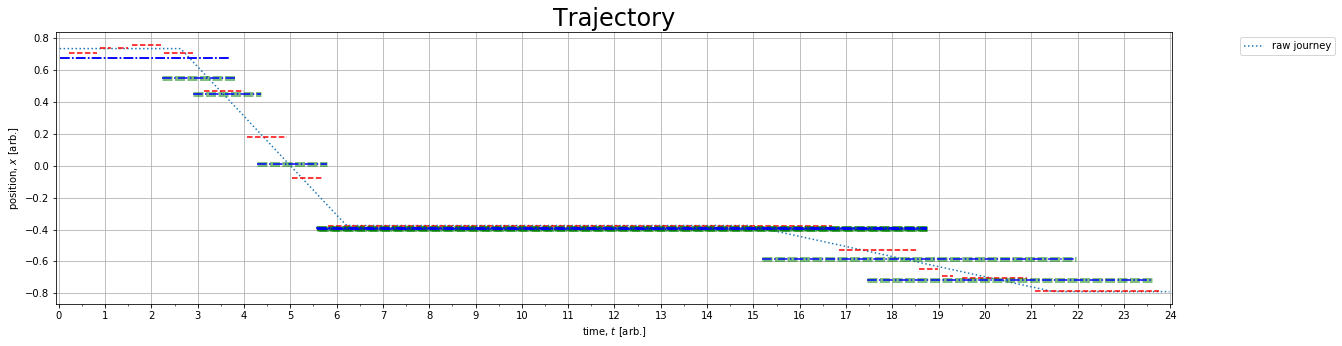

In [68]:
ax = plot_trajectory(time_arr, raw_arr, None, None, None, configs['dist_thresh']);
#'''
for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')#'''

for pair in last_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:', lw=5, dashes=[2,0.5], alpha=0.5)
    
#'''
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')#'''
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [1]:
1

1

In [81]:
intersecting_bounds(1,4,2,3), \
intersecting_bounds(2,3,1,4), \
intersecting_bounds(1,3,2,4), \
intersecting_bounds(2,4,1,3), \
intersecting_bounds(1,2,3,4), \
intersecting_bounds(3,4,1,2)


(True, True, True, True, False, False)

In [82]:
new_last_pairs = []

for m in range(len(last_pairs)):

    n = m+1
    while keep_going
        #for n in range(m+1,len(last_pairs)):
        
        print(last_pairs[m], last_pairs[n])
        
        if inter_bounds(last_pairs[m], last_pairs[n]):
            
            l1 = list(range(last_pairs[m][0],last_pairs[m][1]+1))
            l2 = list(range(last_pairs[n][0],last_pairs[n][1]+1))

            len1 = len(l1)
            len2 = len(l2)        

            s1 = set(l1)
            s2 = set(l2)

            ilen1 = len(list(s1.intersection(s2)))
            ilen2 = len(list(s2.intersection(s1)))

            print(last_pairs[m], len1, last_pairs[n], len2,ilen1,ilen2)
            
            if ilen1/len1 > 0.8:
                new_last_pairs.append(last_pairs[m])
        else:
            new_last_pairs.append(last_pairs[m])
        
        n += 1
                            

SyntaxError: invalid syntax (<ipython-input-82-e2bb16c5f24a>, line 6)

In [83]:
new_last_pairs

NameError: name 'new_last_pairs' is not defined